In [1]:
using CSV, DataFrames, CairoMakie, NonlinearSolve, QuadGK, ForwardDiff

In [11]:
Λ = 0.65
Nf = 2
Nc = 3
G = (9/2)*2.0 / Λ^2 # ???

# Δ is actually |Δ|
Epm(Δ, μ, λ, k, s) = 1/2 * (s*sqrt((k - λ - μ)^2 + 8Nf*Δ^2) + k + λ - μ)
E(μ, k) = k - μ
σ(Δ, μ, λ, k) = sqrt((k - λ - μ)^2 + 8Nf*Δ^2)

θ(x) = x > 0 ? 1 : 0
f0(Δ, μ, λ, k) = θ(-k - λ + μ - σ(Δ, μ, λ,k))*Epm(Δ, μ, λ, k, 1) + θ(-k - λ + μ + σ(Δ, μ, λ,k))*Epm(Δ, μ, λ, k, -1) + θ(μ - k)*E(μ, k)
#I'm not sure if forwarddiff will catch those theta functions
df0dλ(Δ, μ, λ, k) = ForwardDiff.derivative(λi -> f0(Δ, μ, λi, k), λ)

function Ω(Δ, μ, λ)
    I1 = quadgk(k -> k^2*df0dλ(Δ, μ, λ, k), 0, Λ)[1]
    I2 = quadgk(k -> k^2*f0(Δ, μ, λ, k), 0, Λ)[1]

    -λ*Nc/π^2 * I1 + Nc/π^2 * I2 + 8Nf/G * Δ^2
end

gap(Δ, μ, λ) = ForwardDiff.derivative(Δi -> Ω(Δi, μ, λ), Δ)

function solvegap(μ, λ, xmin=0.0, xmax=0.03)
    f(x, param) = gap(x[1], μ, λ)
    xguess = (xmin, xmax)
    prob = IntervalNonlinearProblem(f, xguess, ())
    sol = solve(prob)
    sol.u
end

solvegap (generic function with 3 methods)

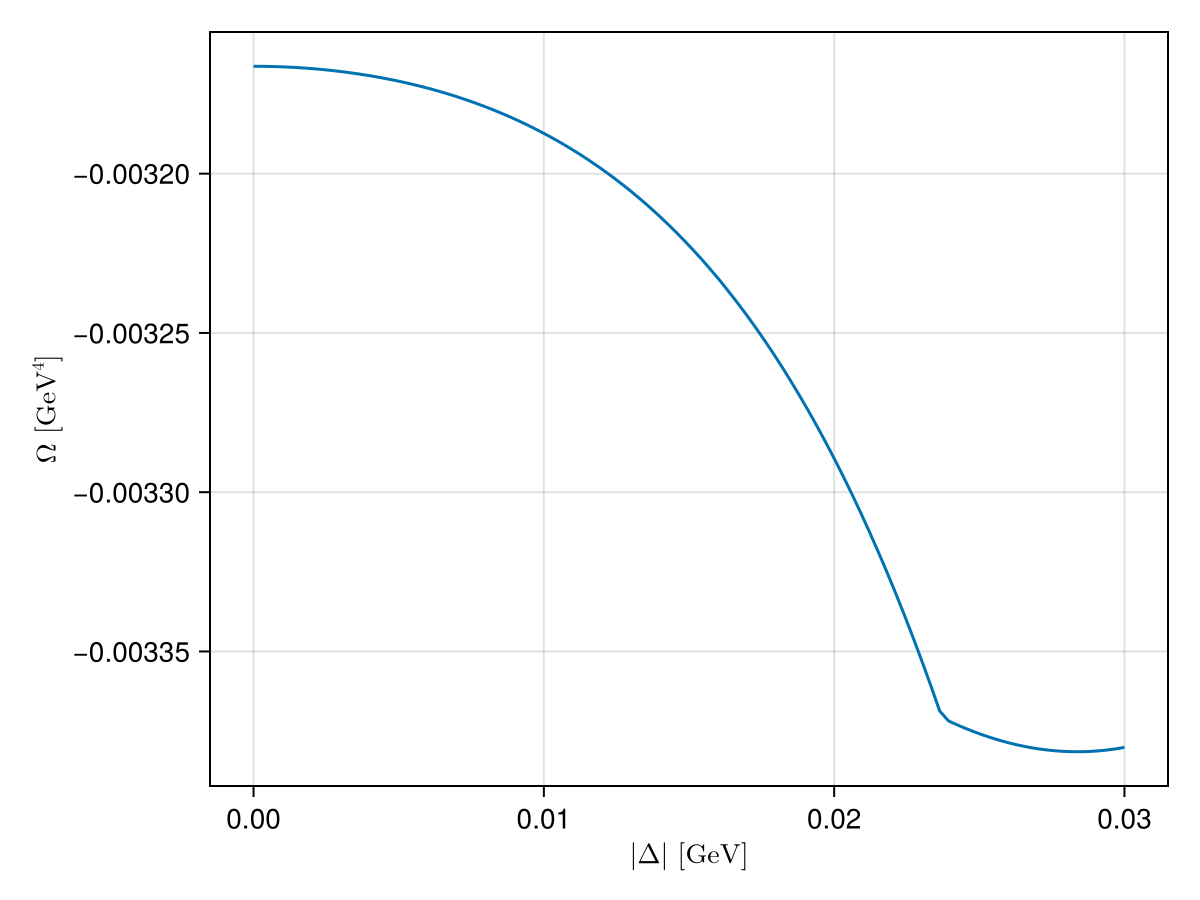

In [17]:
Δvals = range(0.0, 0.030, length=100)
μi = 0.5
λi = 0.015

Ωvals = zeros(size(Δvals))
Threads.@threads for i in eachindex(Δvals)
    Δ = Δvals[i]
    Ωvals[i] = Ω(Δ, μi, λi)
end

fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = L"$|\Delta|$ [GeV]",
    ylabel = L"$\Omega$ [GeV$^4$]"
)

lines!(ax, Δvals, Ωvals)
fig

In [62]:
μi = 0.5
λi = 0.015
#for solving the gap I am using a x1 near zero when I expect a nonzero Δ, and a x1 zero when I expect a zero Δ
#probably the best way to do this is solve the gap in two intervals, then check which one is the global minimum
x1 = 0.005
x2 = 0.03
println(gap(x1, μi, λi))
println(gap(x2, μi, λi))
Δsol = solvegap(μi, λi, x1, x2)
println(Δsol)

-0.0009886509593573138
0.0016915308349447836
0.02837698514690307
